# Import

In [2]:
from interpret import *
from tint.metrics import mse, mae
import tint, captum, gc
from tqdm import tqdm
import pandas as pd
from utils.explainer import *
from exp.exp_interpret import *
from utils.tools import normalize_scale

import matplotlib.pyplot as plt
from utils.plot_config import *
%matplotlib inline

# Util

In [3]:
from data.uea import collate_fn

def prepare_input(
    data, device, args
):
    if args.task_name == 'classification':
        batch_x, batch_y, padding_mask = data
        batch_x = batch_x.float().to(device)
        batch_y= batch_y.float().to(device)
        padding_mask = padding_mask.float().to(device)
        
        inputs = batch_x
        additional_forward_args = (padding_mask, None, None)
    else:
        batch_x, batch_y, batch_x_mark, batch_y_mark = data
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float().to(device)

        batch_x_mark = batch_x_mark.float().to(device)
        batch_y_mark = batch_y_mark.float().to(device)
        # decoder input
        dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
        dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float()
        
        inputs = (batch_x, batch_x_mark)
        additional_forward_args = (dec_inp, batch_y_mark)
    
    return (inputs, additional_forward_args, batch_y)

def prepare_from_dataset(data, device, args):
    if args.task_name == 'classification':
        # already converted to tensor from numpy
        batch_x, batch_y, padding_mask = collate_fn(data)
        batch_x = batch_x.float().to(device)
        batch_y= batch_y.float().to(device)
        padding_mask = padding_mask.float().to(device)
        
        inputs = batch_x
        additional_forward_args = (padding_mask, None, None)
    else:
        batch_x, batch_y, batch_x_mark, batch_y_mark = [
            torch.stack(
                [
                    torch.tensor(d[i], dtype=float, device=device) 
                    for d in data
                ]
            ) 
            for i in range(4)
        ]
        batch_x = torch.tensor(batch_x).float().to(device)
        batch_y = torch.tensor(batch_y).float().to(device)

        batch_x_mark = torch.tensor(batch_x_mark).float().to(device)
        batch_y_mark = torch.tensor(batch_y_mark).float().to(device)
        # decoder input
        dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
        dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float()
        
        inputs = (batch_x, batch_x_mark)
        additional_forward_args = (dec_inp, batch_y_mark)
    
    return (inputs, additional_forward_args, batch_y)

# Arguments

In [34]:
parser = get_parser()

# argv = """
#   --explainers feature_ablation augmented_occlusion feature_permutation winIT tsr wtsr \
#   --task_name classification \
#   --data mimic \
#   --itr_no 1 \
#   --root_path ./dataset/mimic_iii/ \
#   --data_path mimic_iii.pkl \
#   --metrics auc accuracy cross_entropy \
#   --model iTransformer --n_features 31
# """.split()

# --explainers feature_ablation occlusion augmented_occlusion winIT tsr wtsr \

argv = """
  --task_name long_term_forecast \
  --explainers feature_ablation augmented_occlusion feature_permutation winIT tsr wtsr \
  --root_path ./dataset/traffic/ \
  --data_path traffic.csv \
  --model iTransformer \
  --itr_no 1 \
  --features S \
  --seq_len 96 \
  --label_len 12 \
  --pred_len 24 \
  --n_features 1
""".split()

args = parser.parse_args(argv)

# only evaluate on test
args.flag = 'test'
# Disable cudnn if using cuda accelerator.
# Please see https://captum.ai/docs/faq#how-can-i-resolve-cudnn-rnn-backward-error-for-rnn-or-lstm-network
# args.use_gpu = False
initial_setup(args)

# Initialize

## Experiment

In [35]:
if args.task_name == 'classification': Exp = Exp_Classification
else: Exp = Exp_Long_Term_Forecast
exp = Exp(args)  # set experiments

# should be test or validation data
dataset, dataloader = exp._get_data(args.flag)
exp.load_best_model()

model = exp.model
_ = model.eval()
# model.zero_grad()

Use GPU: cuda:0
Experiments will be saved in ./results\traffic_iTransformer\1
test 1731
Loading model from ./results\traffic_iTransformer\1\checkpoint.pth


In [36]:
n_samples = 10
example_no =[]

if args.data_path == 'mimic_iii.pkl':
    for i in range(len(dataset)):
        if dataset[i][1].item() == 1:
            example_no.append(i)
            n_samples -=1

        if n_samples <= 0: break
        
    if len(example_no) < n_samples:
        raise Exception(f'Not enough samples')
else:
    example_no = np.random.randint(0, len(dataset)-1, n_samples)
    print(f'Randomly chosen {example_no}')

Randomly chosen [1672 1530  608  640  539 1572  446  183 1151  316]


## Explainer

In [37]:
from exp.exp_interpret import Exp_Interpret

explainers_map = dict() 
for name in exp.args.explainers:
    explainer = Exp_Interpret.initialize_explainer(
        name, exp.model, exp.args, exp.device, dataloader
    ) 
    explainers_map[name] = explainer

# Input

In [38]:
# inputs, additional_forward_args, labels = prepare_input(
#     next(iter(dataloader)), exp.device, args
# )
if args.task_name == 'classification':
    inputs, additional_forward_args, labels = prepare_from_dataset(
        [dataset[i] for i in example_no], exp.device, args
    )
else: 
    inputs, additional_forward_args, labels = prepare_from_dataset(
        [dataset[i] for i in example_no], exp.device, args
    )
baselines = get_baseline(inputs, args.baseline_mode)

# Interpret

## Explainer

In [39]:
# explainer = FeatureAblation(model)
# explainer = explainers_map[name]
attr_map = dict()

for name in exp.args.explainers:
    print(name)
    explainer = explainers_map[name]
    attr = compute_attr(
        name, inputs, baselines, explainer, 
        additional_forward_args, args
    )
        
    if args.task_name == 'classification':
        attr_numpy = attr.detach().cpu().numpy()
    else:
        attr_numpy = tuple([a.detach().cpu().numpy() for a in attr])

    attr_map[name] = attr_numpy

feature_ablation
augmented_occlusion
feature_permutation
winIT
tsr
wtsr


## Evaluate

In [ ]:
for area in args.areas:
    for metric_name in args.metrics:
        metric = expl_metric_map[metric_name]
        error_comp = metric(
            model, inputs=inputs, 
            attributions=attr[:, target], baselines=baselines, 
            additional_forward_args=additional_forward_args,
            topk=area, mask_largest=True
        )
        
        error_suff = metric(
            model, inputs=inputs, 
            attributions=attr[:, target], baselines=baselines, 
            additional_forward_args=additional_forward_args,
            topk=area, mask_largest=False
        )
        print(f'{area}, {metric_name}, {error_comp:.3g}, {error_suff:.3g}')

# Visualization

In [40]:
sample_no = 0
if args.data_path == 'mimic_iii.pkl': target = 1
else: target = 0
cmap='binary' # binary, RdYlGn, grey, hot

In [55]:
if args.data_path == 'mimic_iii.pkl':
    vital_IDs = ['HeartRate' , 'SysBP' , 'DiasBP' , 'MeanBP' , 'RespRate' , 'SpO2' , 'Glucose' ,'Temp']
    others = ['gender', 'age', 'ethnicity', 'first_icu_stay']
    lab_IDs = [
        'ANION GAP', 'ALBUMIN', 'BICARBONATE', 'BILIRUBIN', 
        'CREATININE', 'CHLORIDE', 'GLUCOSE', 'HEMATOCRIT', 
        # 'HEMOGLOBIN' 'LACTATE' -> 'HEMOGLOBIN', 'LACTATE'. But the source preprocessing uses it like this
        'HEMOGLOBIN' 'LACTATE', 'MAGNESIUM', 'PHOSPHATE', 
        'PLATELET', 'POTASSIUM', 'PTT', 'INR', 
        'PT', 'SODIUM', 'BUN', 'WBC'
    ]
    features = vital_IDs + others + lab_IDs # feature
elif args.data_path == 'electricity.csv':
    features = ['Electricity', 'Hour', 'Weekday', 'Day', 'Month']
elif args.data_path == 'traffic.csv':
    features = ['Traffic', 'Hour', 'Weekday', 'Day', 'Month']
else:
    raise ValueError(f'Data path {args.data_path} not implemented yet')

## All features

In [11]:
def numpy_min_max(data, axis=-1):
    return (data - data.min(axis=axis, keepdims=True)) / (data.max(axis=axis, keepdims=True) - data.min(axis=axis, keepdims=True))

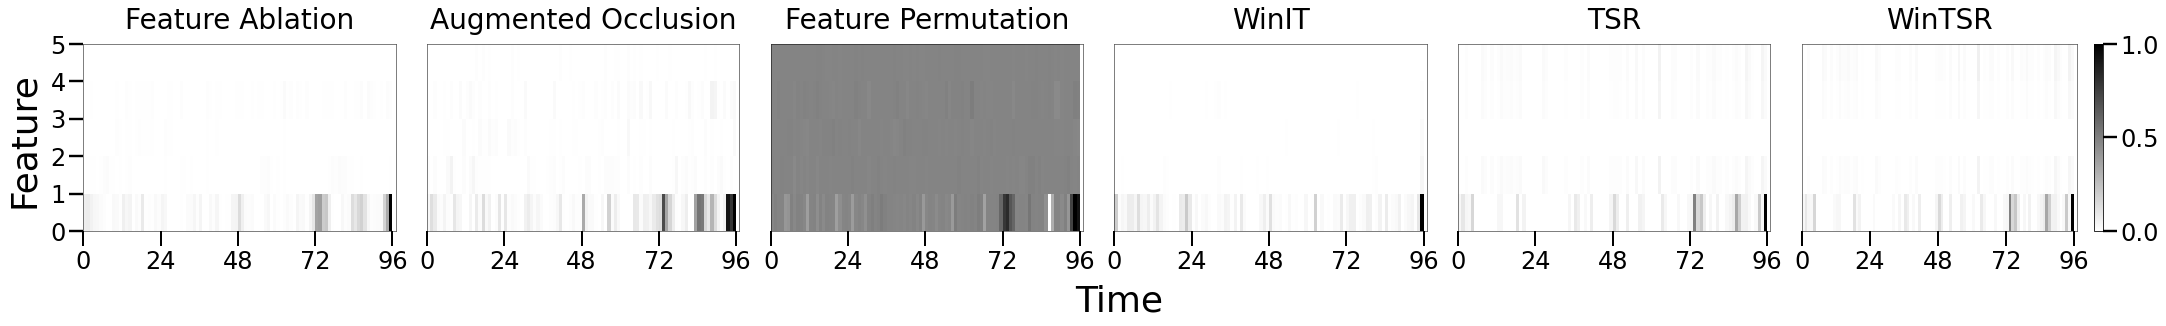

In [63]:
n = len(args.explainers)
rows, columns = 1, n
width_ratios=  [1] * (n-1) + [1.1]

if args.data_path == 'mimic_iii.pkl':
    fig, axes = plt.subplots(rows, columns, figsize =(30, 4), width_ratios=width_ratios)
else:
    fig, axes = plt.subplots(rows, columns, figsize =(30, 4), width_ratios=width_ratios)

for row in range(rows):
    for col in range(columns):
        explainer_no = row * columns + col
        name = args.explainers[explainer_no]
        attr_normed = attr_map[name]
        if type(attr_normed) == tuple:
            # concatenate across feature dimension
            # attr_normed = tuple([numpy_min_max(a, axis=(-2, -1))  for a in attr_normed])
            attr_normed = np.concatenate(attr_normed, axis=-1)
            
            # only use the encoder features
            # attr_normed = attr_normed[0]
            
        attr_normed = numpy_min_max(attr_normed, axis=(-2, -1))
        if rows == 1: 
            if columns == 1: ax = axes
            else: ax = axes[col]
        else: 
            if columns == 1: ax = axes[row]
            else: ax = axes[row][col]
            
        # if only one feature
        if attr_normed.shape[-1] == 1:
            if target is None:
                ax.plot(attr_normed[sample_no].mean(axis=0).T[0])
            else:    
                ax.plot(attr_normed[sample_no, target].T[0])
        else:
            if target is None:
                psm = ax.pcolormesh(
                    attr_normed[sample_no].mean(axis=0).T,
                    cmap=cmap, # vmax=1 # rasterized=True
                )
            else:
                psm = ax.pcolormesh(
                    attr_normed[sample_no, target].T,
                    cmap=cmap, # vmax=1 # rasterized=True
                )
            # colorbar at the rightmost column
            if col + 1 == columns:
                fig.colorbar(psm, ax=ax)
        
        
        # make the axes more visible
        plt.setp(ax.spines.values(), linewidth=0.5) 
        if col > 0:
            ax.get_yaxis().set_visible(False)   
        
        # im = axes[0].imshow(attr_normed[example_no, target].T, cmap='binary', interpolation='nearest')
        # axes[0].figure.colorbar(im, fraction=0.03, pad=0.04)
        # name = explainer_name_map[]
        name = explainer_name_map[name].get_name()
        ax.set_title(name, fontsize=28)
        if args.data_path == 'mimic_iii.pkl':
            ax.xaxis.set_major_locator(MultipleLocator(base=12))
            ax.yaxis.set_major_locator(MultipleLocator(base=10))
        else:
            ax.xaxis.set_major_locator(MultipleLocator(base=24))
            if attr_normed.shape[-1] < 6:
                ax.yaxis.set_major_locator(MultipleLocator(base=1))
        ax.set_xlim(0, ax.get_xlim()[1]+1)

fig.tight_layout()
fig.supylabel('Feature', fontsize=36, x=-.015)
fig.supxlabel('Time', fontsize=36, y=-0.12)
# plt.suptitle('Heat map of feature importance scores')
plt.savefig(f'{exp.output_folder}/heatmap_{example_no[sample_no]}_normed.jpg', dpi=200, bbox_inches="tight")
plt.show()

## Raw input

In [54]:
if type(inputs) == tuple:
    X = torch.concat(inputs, dim=-1).detach().cpu().numpy()
else:
    X = inputs.detach().cpu().numpy()

In [49]:
features[attr_normed[sample_no, target].sum(axis=-2).argmax()]

'Traffic'

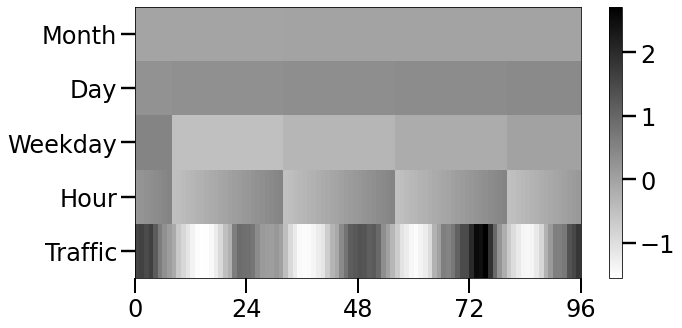

In [56]:
fig, ax = plt.subplots(1, 1, figsize =(10, 5))
psm = ax.pcolormesh(
    X[sample_no].T, 
    cmap=cmap, # vmin=0, vmax=1 # rasterized=True
)
fig.colorbar(psm, ax=ax)

if args.data_path != 'mimic_iii.pkl':
    ax.yaxis.set_major_locator(MultipleLocator(base=1))
    ax.set_yticks([i+ 0.5 for i in range(len(features))], labels=features)
    
    ax.xaxis.set_major_locator(MultipleLocator(base=24))
else:
    ax.yaxis.set_major_locator(MultipleLocator(base=10))
    ax.xaxis.set_major_locator(MultipleLocator(base=12))

plt.savefig(f'{exp.output_folder}/example_{example_no[sample_no]}.jpg', dpi=200, bbox_inches="tight")
plt.show()

# WIP

## Density plot

In [ ]:
# import scipy.stats as st
# fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# n_bins = 128

# dist1 = attr_normed[:, target, :, feature_no].flatten()
# dist2 = tsr_attr_normed[:, target, :, feature_no].flatten()

# _ = axes[0].hist(dist1, bins=n_bins, density=True)
# # We can set the number of bins with the *bins* keyword argument.
# kde = st.gaussian_kde(dist1)
# mn, mx = axes[0].get_xlim()
# kde_xs = np.linspace(mn, mx, 100)
# axes[0].plot(kde_xs, kde.pdf(kde_xs), label="PDF", color='black')
# axes[0].set_ylabel('Count')
# axes[0].set_xlabel(f'{explainer.get_name()}')
# axes[0].set_xlim(-0.1, 1)

# _ = axes[1].hist(dist2, bins=n_bins, density=True)
# axes[1].set_xlabel(f'WTSR + {explainer.get_name()}')
# kde = st.gaussian_kde(dist2)
# mn, mx = axes[1].get_xlim()
# kde_xs = np.linspace(mn, mx, 100)
# axes[1].plot(kde_xs, kde.pdf(kde_xs), label="PDF", color='black')
# axes[1].set_xlim(-0.1, 1)
# # plt.suptitle('Histogram and density plot of feature importance scores')
# fig.tight_layout()
# # plt.savefig('results/density.jpg', dpi=200)

## WinTSR

In [ ]:
from attrs.winTSR import WinTSR
explainer = WinTSR(model, args)

In [ ]:
attr = explainer.attribute(
    inputs, baselines, 
    additional_forward_args, 
    attributions_fn=abs
)

## Visualize

In [ ]:
fig, axes = plt.subplots(1, 2, figsize =(16, 5))

psm = axes[0].pcolormesh(
    attr_normed[example_no, target].T, 
    cmap=cmap, # rasterized=True, # vmin=0, vmax=1
)
fig.colorbar(psm, ax=axes[0])
# im = axes[0].imshow(attr_normed[example_no, target].T, cmap='binary', interpolation='nearest')
# axes[0].figure.colorbar(im, fraction=0.03, pad=0.04)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Feature')


psm = axes[1].pcolormesh(
    attr[example_no, target].T, 
    cmap=cmap, # rasterized=True, # vmin=0, vmax=1
)
fig.colorbar(psm, ax=axes[1])
axes[1].set_xlabel('Time')

fig.tight_layout()
# plt.suptitle('Heat map of feature importance scores')
# plt.savefig('results/heatmap.jpg', dpi=200)
plt.show()

## Evaluate

In [ ]:
for area in args.areas:
    for metric_name in args.metrics:
        metric = expl_metric_map[metric_name]
        error_comp = metric(
            model, inputs=inputs, 
            attributions=avg_wtsr_attr, baselines=baselines, 
            additional_forward_args=additional_forward_args,
            topk=area, mask_largest=True
        )
        
        error_suff = metric(
            model, inputs=inputs, 
            attributions=avg_wtsr_attr, baselines=baselines, 
            additional_forward_args=additional_forward_args,
            topk=area, mask_largest=False
        )
        print(f'{area}, {metric_name}, {error_comp:.3g}, {error_suff:.3g}')